# Kaggle Bike Demard Problem¶

Kaggle Bike Demard forecasting competition https://www.kaggle.com/c/bike-sharing-demand provides bike share useage data from the Capital Bikeshare program in Washington, D.C. The bike usage by hour is provided from the 1st - 20th of each month from Jan-2011 through to Dec-2012. The 20th to the end of the month are held back for testing the quality of the forecasting model.

In [76]:
%matplotlib inline

import math
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
from sklearn import preprocessing

In [156]:
def b(x):
    if x == True:
        return 1.0
    else:
        return 0.0

def readit(path):
    xs = pd.read_csv(path, parse_dates = {'dateTime': ['datetime']})
    xs['weekday']        = xs['dateTime'].apply(lambda x: x.weekday())
    xs['hour']           = xs['dateTime'].apply(lambda x: x.hour)
    xs['weather']        = xs['weather'].astype(int)
    xs['date']           = xs['dateTime'].apply(lambda x: x.toordinal())
    xs['month']          = xs['dateTime'].apply(lambda x: x.month)
    xs['year']           = xs['dateTime'].apply(lambda x: x.year)
    xs['temp']           = xs['temp'].astype(float)
    xs['atemp']          = xs['atemp'].astype(float)
    xs['humidity']       = xs['humidity'].astype(float)
    xs['windspeed']      = xs['windspeed'].astype(float)
    xs['temp_log']       = np.log(xs['temp'])
    xs['atemp_log']      = np.log(xs['atemp'])
    xs['windspeed_log']  = np.log(xs['windspeed'])
    
    # Below (under Exploration) we notice that average riders per period
    # looks like a periodic function. Here we try to approximate it using
    # the sum of one or two `sin` functions.
    xs['work_sin_hr_0']  = xs.apply(lambda x: b(x.workingday == 1)
                                    * math.sin(x.hour*math.pi/12 + 5*math.pi/4), axis=1)
    xs['work_sin_hr_1']  = xs.apply(lambda x: b(x.workingday == 1)
                                    * math.sin(x.hour*math.pi/6  + 5*math.pi/4), axis=1)
    xs['work_sin_mon']   = xs.apply(lambda x: b(x.workingday == 1)
                                    * math.sin((x.month - 1)*math.pi/12 + math.pi/8), axis=1)

    xs['rest_sin_hr']    = xs.apply(lambda x: b(x.workingday == 0)
                                    * math.sin(x.hour*math.pi/12) + math.pi/8, axis=1)
    xs['rest_sin_mon']   = xs.apply(lambda x: b(x.workingday == 0)
                                    * math.sin((x.month - 1)*math.pi/12 + math.pi/8), axis=1)

    return xs.set_index('dateTime')

def trainit(train):    
    train['count']          = train['count'].astype(int)
    train['casual']         = train['casual'].astype(int)
    train['registered']     = train['registered'].astype(int)
    
    train['count_log']      = train['count'].apply(lambda x: math.log(x + 1))
    train['casual_log']     = train['casual'].apply(lambda x: math.log(x + 1))
    train['registered_log'] = train['registered'].apply(lambda x: math.log(x + 1))
    return train


ftest = readit('data/test.csv')
train = trainit(readit('data/train.csv'))

## Exploration

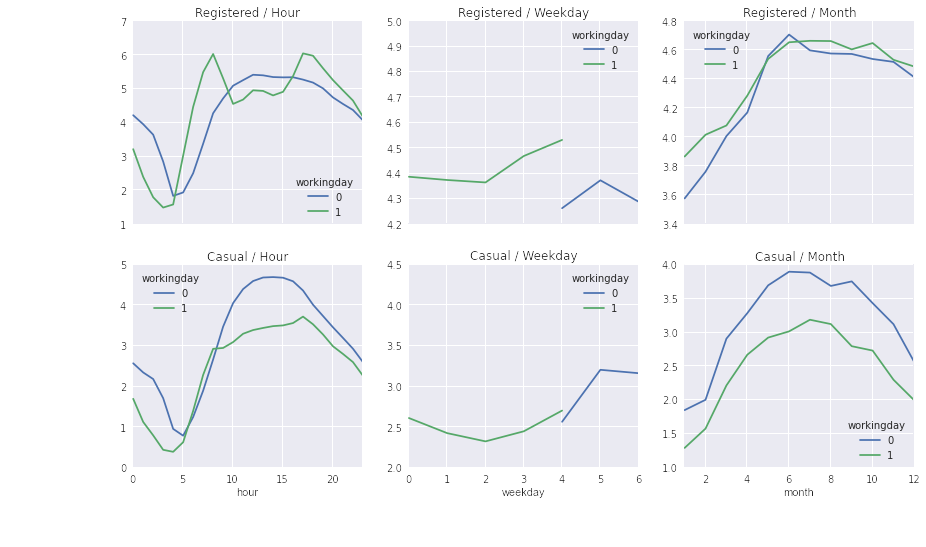

In [25]:
f, axes = plt.subplots(2, 3, figsize=(14,8))

axes[0][0].set_title('Registered / Hour')
axes[0][1].set_title('Registered / Weekday')
axes[0][2].set_title('Registered / Month')
train.pivot_table(index=['hour'],    values='registered_log', columns='workingday', aggfunc=np.mean).plot(kind='line', ax=axes[0][0])
train.pivot_table(index=['weekday'], values='registered_log', columns='workingday', aggfunc=np.mean).plot(kind='line', ax=axes[0][1])
train.pivot_table(index=['month'],   values='registered_log', columns='workingday', aggfunc=np.mean).plot(kind='line', ax=axes[0][2])

axes[1][0].set_title('Casual / Hour')
axes[1][1].set_title('Casual / Weekday')
axes[1][2].set_title('Casual / Month')
train.pivot_table(index=['hour'],    values='casual_log', columns='workingday', aggfunc=np.mean).plot(kind='line', ax=axes[1][0])
train.pivot_table(index=['weekday'], values='casual_log', columns='workingday', aggfunc=np.mean).plot(kind='line', ax=axes[1][1])
train.pivot_table(index=['month'],   values='casual_log', columns='workingday', aggfunc=np.mean).plot(kind='line', ax=axes[1][2])

There's clearly some periodic quality to our data. We could try modeling this trend using a continuous function, like `-B*sin(hour)`, but since we're not required to predict counts between hours, we can simply build a lookup table that maps each hour to the mean target value at that hour.

In [157]:
# Note we don't have enough examples to further partition 'weekday' by 'workingday'.
mean_hr_reg = train.groupby(['workingday','hour'   ]).agg({'registered_log': 'mean'}).to_dict()
mean_mo_reg = train.groupby(['workingday','month'  ]).agg({'registered_log': 'mean'}).to_dict()
mean_wd_reg = train.groupby([             'weekday']).agg({'registered_log': 'mean'}).to_dict()

mean_hr_cas = train.groupby(['workingday','hour'   ]).agg({'casual_log':     'mean'}).to_dict()
mean_mo_cas = train.groupby(['workingday','month'  ]).agg({'casual_log':     'mean'}).to_dict()
mean_wd_cas = train.groupby([             'weekday']).agg({'casual_log':     'mean'}).to_dict()

def mean_features(df):
    # mean_hr_reg, mean_mo_reg, mean_hr_cas, mean_mo_cas
    df['mean_hr_reg'] = df.apply(lambda x: mean_hr_reg['registered_log'][(x.workingday, x.hour)],  axis=1).astype(float)
    df['mean_wd_reg'] = df.apply(lambda x: mean_wd_reg['registered_log'][x.weekday],               axis=1).astype(float)
    df['mean_mo_reg'] = df.apply(lambda x: mean_mo_reg['registered_log'][(x.workingday, x.month)], axis=1).astype(float)

    df['mean_hr_cas'] = df.apply(lambda x: mean_hr_cas['casual_log'][(x.workingday, x.hour)],  axis=1).astype(float)
    df['mean_wd_cas'] = df.apply(lambda x: mean_wd_cas['casual_log'][x.weekday],               axis=1).astype(float)
    df['mean_mo_cas'] = df.apply(lambda x: mean_mo_cas['casual_log'][(x.workingday, x.month)], axis=1).astype(float)

mean_features(train)
mean_features(ftest)

ftest[['mean_hr_reg', 'mean_wd_reg', 'mean_mo_reg', 'mean_hr_cas', 'mean_wd_cas', 'mean_mo_cas']].head()

,mean_hr_reg,mean_wd_reg,mean_mo_reg,mean_hr_cas,mean_wd_cas,mean_mo_cas
dateTime,,,,,,
2011-01-20 00:00:00,3.221928,4.46924,3.86782,1.700076,2.449739,1.294032
2011-01-20 01:00:00,2.402258,4.46924,3.86782,1.129750,2.449739,1.294032
2011-01-20 02:00:00,1.799900,4.46924,3.86782,0.799156,2.449739,1.294032
2011-01-20 03:00:00,1.495082,4.46924,3.86782,0.443198,2.449739,1.294032
2011-01-20 04:00:00,1.586807,4.46924,3.86782,0.393860,2.449739,1.294032


In [27]:
import random
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

def fitModel(formula,all_data,test,holdout,target):
    res = smf.ols(formula=formula,data=test).fit()
    res_all = smf.ols(formula=formula,data=all_data).fit()
    
    holdout['predicted'] = res.predict(holdout) 
    test['predicted'] = res.predict(test) 
    all_data['predicted_test'] =  res.predict(all_data) 
    all_data['predicted_all'] =  res_all.predict(all_data) 
    
    # MSE
    mn  = np.mean(holdout[target])
    tot = np.sum((holdout[target] - mn)**2)
    rss = np.sum((holdout[target] - holdout['predicted'])**2)
    # score = 1 - rss/tot
    score = rss / holdout.size

    #fstat
    p_val = sp.stats.f_oneway(test['predicted'],holdout['predicted'])[1]

    ax = plt.subplot(131)
    plt.scatter(test[target],test['predicted'],color=sns.color_palette()[2],s=10, marker='o')
    ax.set_title('Test Fit')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    ax = plt.subplot(132)
    plt.scatter(holdout[target],holdout['predicted'],color=sns.color_palette()[1],s=10, marker='o')
    ax.set_title('Holdout Fit')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    
    ax = plt.subplot(133)
    plt.scatter(all_data[target],all_data['predicted_all'],color=sns.color_palette()[2],s=10, marker='o',alpha=0.5)
    plt.scatter(all_data[target],all_data['predicted_test'],color=sns.color_palette()[1],s=10, marker='o',alpha=0.2)
    ax.set_title('All Fit')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    
    plt.show()
        
    return (res,res_all,score,p_val)

## Let's fit `registered` with a linear model

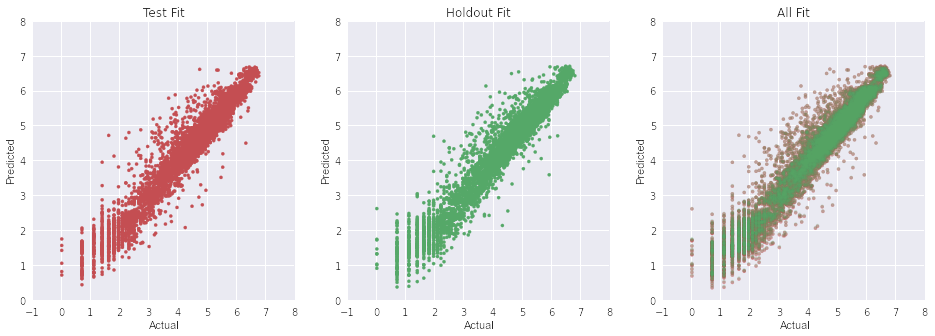

score on holdout group is 0.00394087170475
p-value on test & holdout predictions are 0.103816554654


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         registered_log   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 1.279e+04
Date:                Tue, 14 Apr 2015   Prob (F-statistic):               0.00
Time:                        12:58:52   Log-Likelihood:                -4763.6
No. Observations:               10886   AIC:                             9551.
Df Residuals:                   10874   BIC:                             9639.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept     -1084.2462     14.573    -74.403      0.000     -1112.811 -1055.681
atemp_log         0.2892      0.015     19.386      0.000         0.260     0.318
year              0.5351      0.007     73.873      0.000         0.521     0.549
month             0.0112      0.005      2.223      0.026         0.001     0.021
mean_hr_reg       0.9978      0.006    165.467      0.000         0.986     1.010
mean_wd_reg       0.9249      0.059     15.726      0.000         0.810     1.040
mean_mo_reg       0.6705      0.048     14.028      0.000         0.577     0.764
work_sin_hr_0    -0.0259      0.011     -2.429      0.015        -0.047    -0.005
work_sin_hr_1     0.0141      0.009      1.562      0.118        -0.004     0.032
work_sin_mon     -0.1213      0.036     -3.326      0.001        -0.193    -0.050
rest_sin_hr       0.0276      0.011      2.458      0.014         0.006     0.050
rest_sin_mon      0.0614      0.034      1.789      0.074        -0.006     0.129
==============================================================================
Omnibus:                     3096.632   Durbin-Watson:                   0.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18825.487
Skew:                          -1.225   Prob(JB):                         0.00
Kurtosis:                       8.958   Cond. No.                     8.16e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
p_val = 1
while p_val > 0.05:
    rows    = random.sample(train.index, len(train)//2)
    test    = train.ix[rows]
    holdout = train.drop(rows)
    fstat1, p_val = sp.stats.f_oneway(test['registered_log'], holdout['registered_log'])

formula = """
    registered_log  ~
      atemp_log     +
      year          +
      month         +
      mean_hr_reg   +
      mean_wd_reg   +
      mean_mo_reg   +
      work_sin_hr_0 +
      work_sin_hr_1 +
      work_sin_mon  +
      rest_sin_hr   +
      rest_sin_mon """

plt.figure(figsize=(16, 5))
res, lin_registered, mse_registered, pval = fitModel(formula, train, test, holdout, 'registered_log')
print 'score on holdout group is %s' % mse_registered
print 'p-value on test & holdout predictions are %s' % pval
lin_registered.summary()

## Distribution of errors in `registered`

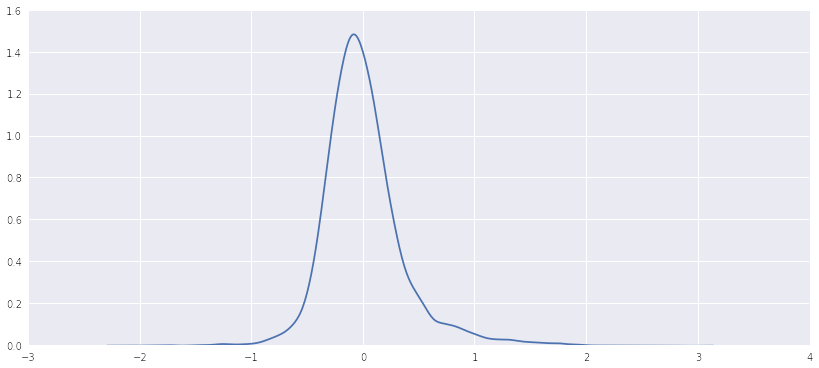

In [75]:
from scipy.stats import gaussian_kde

# Truncate the predicted value to between 0 and maximum seen in training
err = lin_registered.predict(train).clip(0, np.max(train.registered_log)) - train.registered_log
kde = gaussian_kde(err)
xxs = np.arange(err.min(), err.max(), 0.01)

plt.figure(figsize=(14, 6))
plt.plot(xxs, kde(xxs))

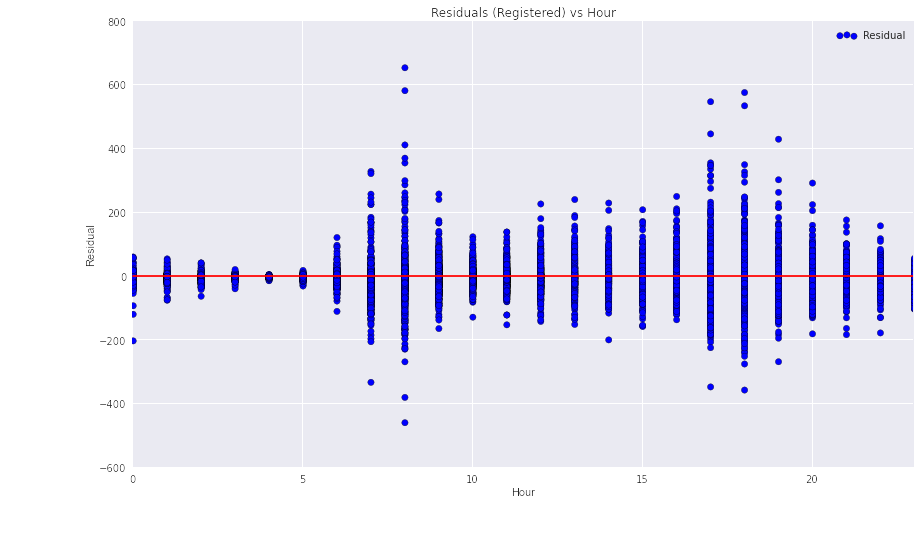

In [51]:
plt.figure(figsize=(14,8))

# Translate prediction of log(casual) back to casual
prd = np.exp(lin_registered.predict(train).clip(0, np.max(train.registered_log)) + mse_registered/2) - 1
plt.scatter(train.hour, prd - np.exp(train.registered_log), c='b', s=40, label='Residual')
plt.plot([train.hour.min(), train.hour.max()], [0,0], c='r')
plt.xlim( train.hour.min(), train.hour.max())

plt.legend()
plt.title('Residuals (Registered) vs Hour')
plt.xlabel('Hour')
plt.ylabel('Residual')

## Let's fit `casual` with a linear model

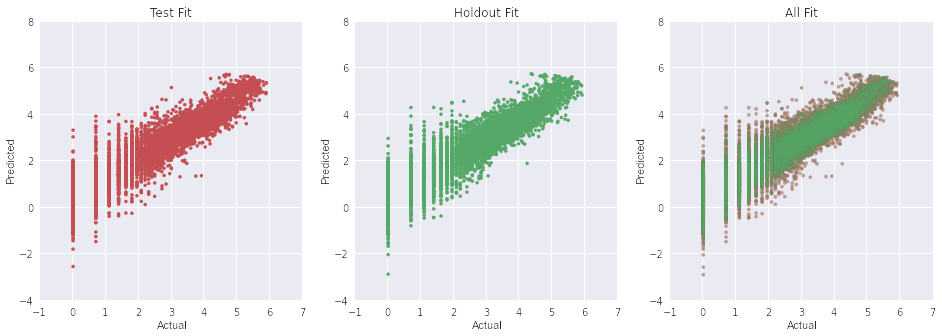

score on holdout group is 0.010672515687
p-value on test & holdout predictions are 0.0574564529354


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             casual_log   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     4825.
Date:                Tue, 14 Apr 2015   Prob (F-statistic):               0.00
Time:                        12:59:19   Log-Likelihood:                -10151.
No. Observations:               10886   AIC:                         2.033e+04
Df Residuals:                   10874   BIC:                         2.041e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      -652.5966     23.893    -27.313      0.000      -699.432  -605.761
atemp_log         0.8047      0.025     32.759      0.000         0.757     0.853
year              0.3222      0.012     27.116      0.000         0.299     0.345
month             0.0795      0.007     10.924      0.000         0.065     0.094
mean_hr_cas       0.9474      0.010     91.566      0.000         0.927     0.968
mean_wd_cas       0.3225      0.035      9.213      0.000         0.254     0.391
mean_mo_cas       0.1182      0.039      3.030      0.002         0.042     0.195
work_sin_hr_0    -0.0146      0.018     -0.809      0.419        -0.050     0.021
work_sin_hr_1     0.0448      0.011      4.202      0.000         0.024     0.066
work_sin_mon      0.9227      0.074     12.418      0.000         0.777     1.068
rest_sin_hr       0.0226      0.019      1.167      0.243        -0.015     0.061
rest_sin_mon      0.6567      0.094      7.015      0.000         0.473     0.840
==============================================================================
Omnibus:                     1130.951   Durbin-Watson:                   0.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2109.113
Skew:                          -0.698   Prob(JB):                         0.00
Kurtosis:                       4.643   Cond. No.                     8.15e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
p_val = 1
while p_val > 0.05:
    rows    = random.sample(train.index, len(train)//2)
    test    = train.ix[rows]
    holdout = train.drop(rows)
    fstat1, p_val   = sp.stats.f_oneway(test['casual_log'], holdout['casual_log'])

formula = """
    casual_log      ~
      atemp_log     +
      year          +
      month         +
      mean_hr_cas   +
      mean_wd_cas   +
      mean_mo_cas   +
      work_sin_hr_0 +
      work_sin_hr_1 +
      work_sin_mon  +
      rest_sin_hr   +
      rest_sin_mon """

plt.figure(figsize=(16, 5))
res, lin_casual, mse_casual, pval = fitModel(formula, train, test, holdout, 'casual_log')
print 'score on holdout group is %s' % mse_casual
print 'p-value on test & holdout predictions are %s' % pval
lin_casual.summary()

## Distribution of error in `casual`

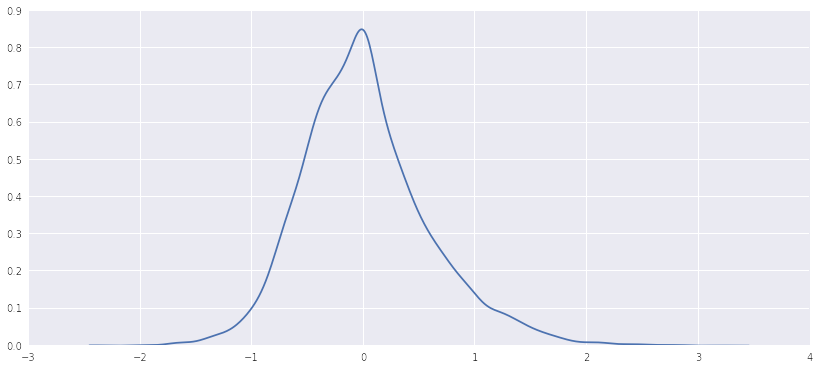

In [19]:
from scipy.stats import gaussian_kde

# Truncate the predicted value to between 0 and maximum seen in training
err = lin_casual.predict(train).clip(0, np.max(train.casual_log)) - train.casual_log
kde = gaussian_kde(err)
xxs = np.arange(err.min(), err.max(), 0.01)

plt.figure(figsize=(14, 6))
plt.plot(xxs, kde(xxs))

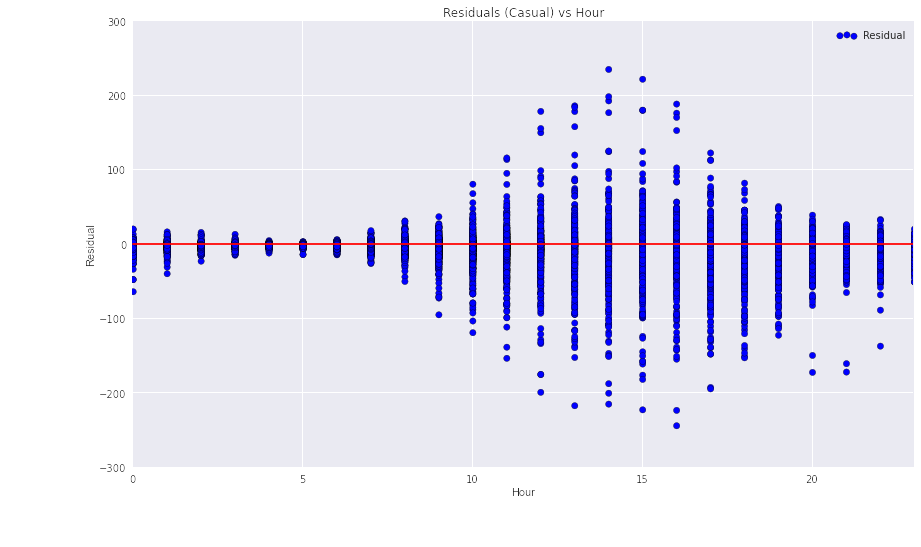

In [52]:
plt.figure(figsize=(14,8))

# Translate prediction of log(casual) back to casual
prd = np.exp(lin_casual.predict(train).clip(0, np.max(train.casual_log)) + mse_casual/2) - 1
plt.scatter(train.hour, prd - np.exp(train.casual_log), c='b', s=40, label='Residual')
plt.plot([train.hour.min(), train.hour.max()], [0,0], c='r')
plt.xlim( train.hour.min(), train.hour.max())

plt.legend()
plt.title('Residuals (Casual) vs Hour')
plt.xlabel('Hour')
plt.ylabel('Residual')

## Generate Predictions for Submission

In [53]:
if 'count' in ftest.columns:
    ftest.drop('count', axis=1, inplace=True)
    
reg = np.exp(lin_registered.predict(ftest).clip(0, np.max(train.registered_log)) + mse_registered/2) - 1
cas = np.exp(    lin_casual.predict(ftest).clip(0, np.max(train.casual_log))     + mse_casual/2)     - 1

ftest['count'] = reg + cas
ftest['count'] = ftest['count'].clip(0, np.max(train['count']))
ftest[['count']].to_csv('submission-01.csv')

## Boosted Regression Trees

In [54]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

features = [
  'season'
, 'holiday'
, 'workingday'
, 'weather'
, 'temp'
# 'temp_log'
, 'atemp'
# 'atemp_log'
, 'humidity'
, 'windspeed'
, 'weekday'
, 'hour'
# 'date'
, 'month'
, 'year'
# 'work_sin_hr_0'
# 'work_sin_hr_1'
# 'work_sin_mon'
# 'rest_sin_hr'
# 'rest_sin_mon'
, 'mean_hr_reg'
, 'mean_wd_reg'
, 'mean_mo_reg'
, 'mean_hr_cas'
, 'mean_wd_cas'
, 'mean_mo_cas'
]

def rmsele(actual, pred):
    squared_error = (pred - actual) ** 2
    mean_squared  = np.sum(squared_error) / len(squared_error)
    return np.sqrt(mean_squared)

scorer = make_scorer(rmsele, greater_is_better=False)

## Let's fit `registered` with a boosted regression tree

In [55]:
from sklearn.grid_search import GridSearchCV
X, y   = shuffle(train[features], train['registered_log'])
X      = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)

X_train, y_train = X[:offset], y[:offset]
X_test, y_test   = X[offset:], y[offset:]

###############################################################################
params = [{'max_features':     ['sqrt'],# 'log2', 'auto'],
           'max_depth':        [5, 8, 12],
           'min_samples_leaf': [2, 5, 10]}]
gscv   = GridSearchCV(ensemble.GradientBoostingRegressor(
        n_estimators      = 300,
        max_depth         = 8,
        min_samples_split = 1,
        learning_rate     = 0.02,
        loss              = 'ls'), params, cv=3, verbose=1, scoring=scorer, n_jobs=4).fit(X_train, y_train)

gbr_registered = gscv.best_estimator_
print gbr_registered

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  21 out of  27 | elapsed:   21.6s remaining:    6.2s
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:   31.2s finished


GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.02, loss='ls',
             max_depth=8, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=10, min_samples_split=1,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)


MSE: 0.0773


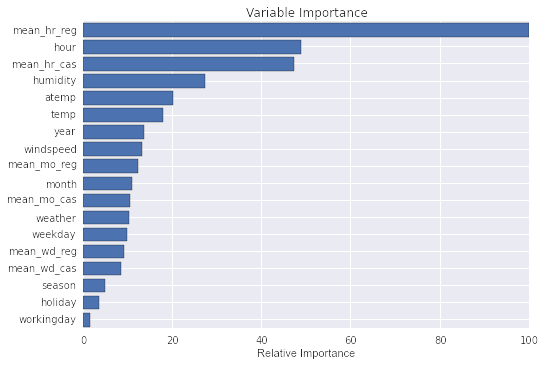

In [56]:
mse_registered = mean_squared_error(y_test, gbr_registered.predict(X_test))
print("MSE: %.4f" % mse_registered)

plt.figure()
feature_i  = gbr_registered.feature_importances_
feature_i  = 100.0 * feature_i / feature_i.max()
sorted_idx = np.argsort(feature_i)
position   = np.arange(sorted_idx.shape[0]) + .5
plt.barh(position, feature_i[sorted_idx], align='center')

yticks = []
for i in sorted_idx:
    yticks.append(features[i])
plt.yticks(position, yticks)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Let's fit `casual` with a boosted regression tree

In [57]:
X, y   = shuffle(train[features], train['casual_log'])
X      = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)

X_train, y_train = X[:offset], y[:offset]
X_test, y_test   = X[offset:], y[offset:]

###############################################################################
params = [{'max_features':     ['sqrt'],# 'log2', 'auto'],
           'max_depth':        [5, 8, 12],
           'min_samples_leaf': [2, 5, 10]}]
gscv   = GridSearchCV(ensemble.GradientBoostingRegressor(
        n_estimators      = 300,
        max_depth         = 8,
        min_samples_split = 1,
        learning_rate     = 0.02,
        loss              = 'ls'), params, cv=3, verbose=1, scoring=scorer, n_jobs=4).fit(X_train, y_train)

gbr_casual = gscv.best_estimator_
print gbr_casual

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  21 out of  27 | elapsed:   22.4s remaining:    6.4s
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:   31.4s finished


GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.02, loss='ls',
             max_depth=8, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=10, min_samples_split=1,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)


MSE: 0.2261


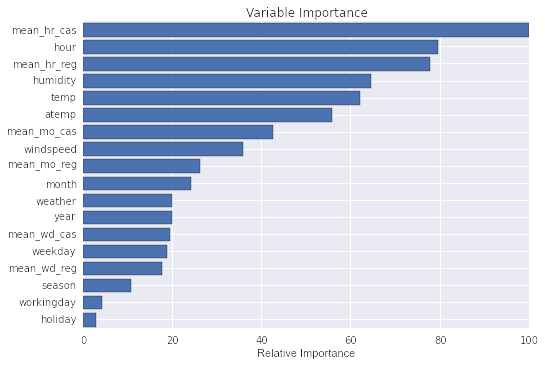

In [58]:
casual_mse = mean_squared_error(y_test, gbr_casual.predict(X_test))
print("MSE: %.4f" % casual_mse)

plt.figure()
feature_i  = gbr_casual.feature_importances_
feature_i  = 100.0 * feature_i / feature_i.max()
sorted_idx = np.argsort(feature_i)
position   = np.arange(sorted_idx.shape[0]) + .5

plt.barh(position, feature_i[sorted_idx], align='center')

yticks = []
for i in sorted_idx:
    yticks.append(features[i])
plt.yticks(position, yticks)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Generate Predictions for Submission

In [60]:
if 'count' in ftest.columns:
    ftest.drop('count', axis=1, inplace=True)

reg = np.exp(gbr_registered.predict(ftest[features]).clip(0, np.max(train.registered_log)) + mse_registered/2) - 1
cas = np.exp(    gbr_casual.predict(ftest[features]).clip(0, np.max(train.casual_log    )) + mse_casual/2)     - 1

ftest['count'] = reg + cas
ftest['count'] = ftest['count'].clip(0, np.max(train['count']))
ftest[['count']].to_csv('submission-02.csv')

## Exploring Autocorrelation

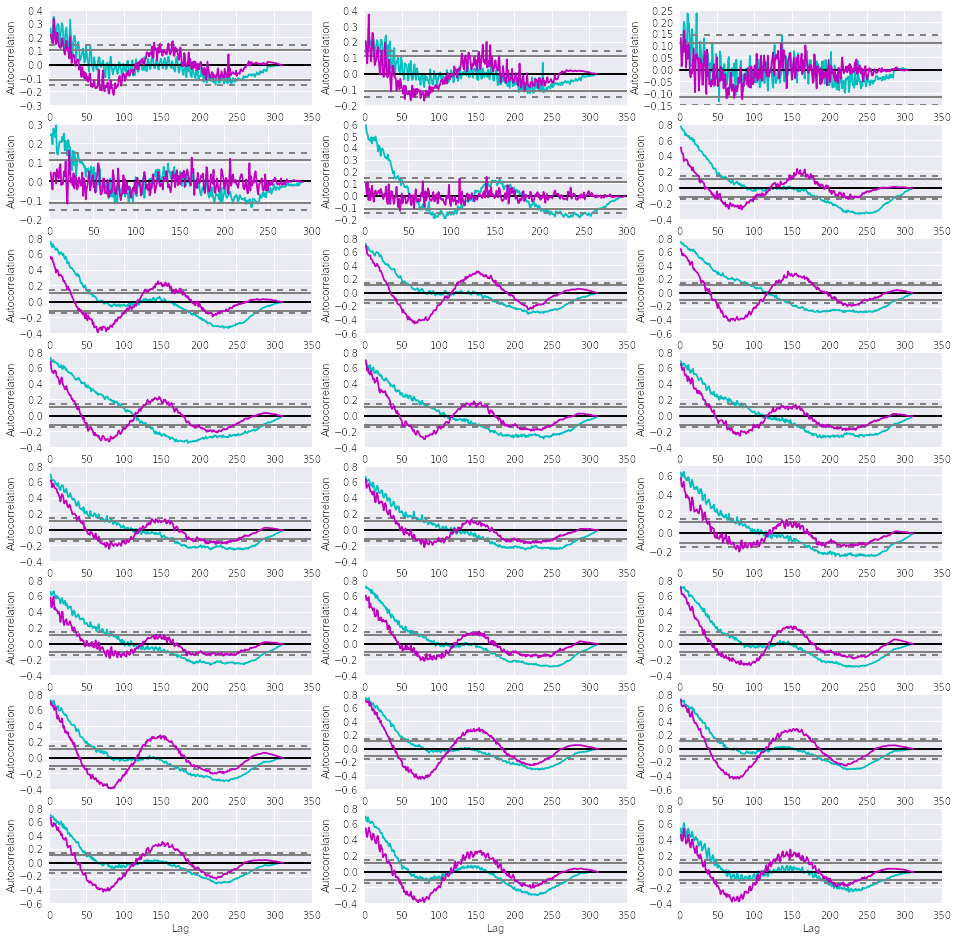

In [73]:
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot

# Registered & Casual on Workingdays
fig, axes = plt.subplots(ncols=3, nrows=8, figsize=(16, 16))
for h in range(24):
    autocorrelation_plot(train.registered[train.hour == h][train.workingday == 1], ax=axes[int(h / 3.0)][h % 3], color='c')
    autocorrelation_plot(train.casual[    train.hour == h][train.workingday == 1], ax=axes[int(h / 3.0)][h % 3], color='m')

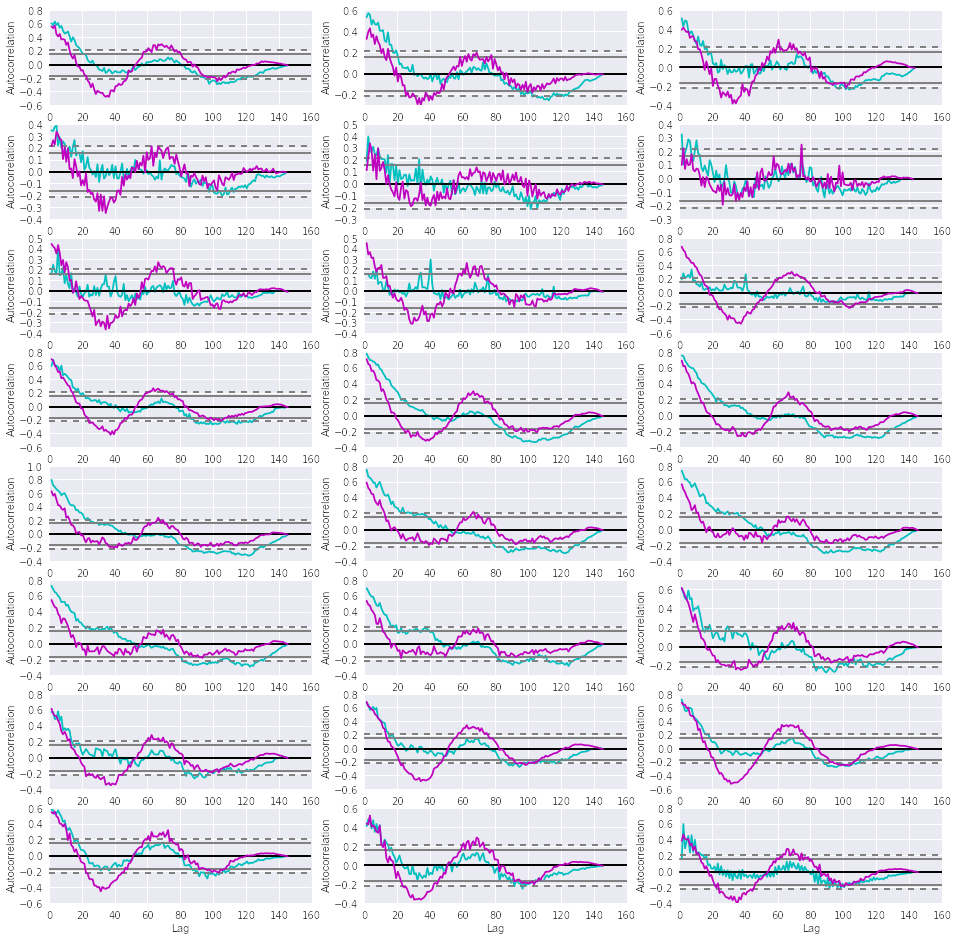

In [72]:
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot

# Registered & Casual on Non-Workingdays
fig, axes = plt.subplots(ncols=3, nrows=8, figsize=(16, 16))
for h in range(24):
    autocorrelation_plot(train.registered[train.hour ==  h][train.workingday == 0], ax=axes[int(h / 3.0)][h % 3], color='c')
    autocorrelation_plot(train.casual[    train.hour ==  h][train.workingday == 0], ax=axes[int(h / 3.0)][h % 3], color='m')

Next I'd like to take advantage of this correlation (and anti-correlation) by adding four features to each observation:

1. `cas_corr`: To predict `casual`, the mean value of the `casual` for the prior 10 samples
for non-workingdays, or the mean value of `casual` for the prior ~30 samples for workingdays.
This feature is positively correlated with `casual`.

2. `cas_anti`: To predict `casual`, the mean value of `casual` for 25-35 samples prior for
non-workingdays, or the mean value of `casual` for 60-80 samples prior for workingdays.
This feature is negatively correlated with `casual`.

3. `reg_corr`: To predict `registered`, the mean value of `registered` for the prior 10
samples for non-workingdays, or the mean value of `registered` for the prior 50 samples for
workingdays. This feature is positively correlated with `registered`.

4. `reg_anti`: To predict `registered`, the mean value of `registered` for the 80-100 samples
prior for non-workingdays, or the mean value of `registered` for 200-250 samples prior for
workingdays. This feature is negatively correlated with `registered`.


## Exploiting the Error Function

Cost of guessing 50% low
(800, 0.6918995197617903)
(400, 0.6906565192474936)
(200, 0.688184391217816)
(100, 0.683294884116934)
(50, 0.6737290947028436)


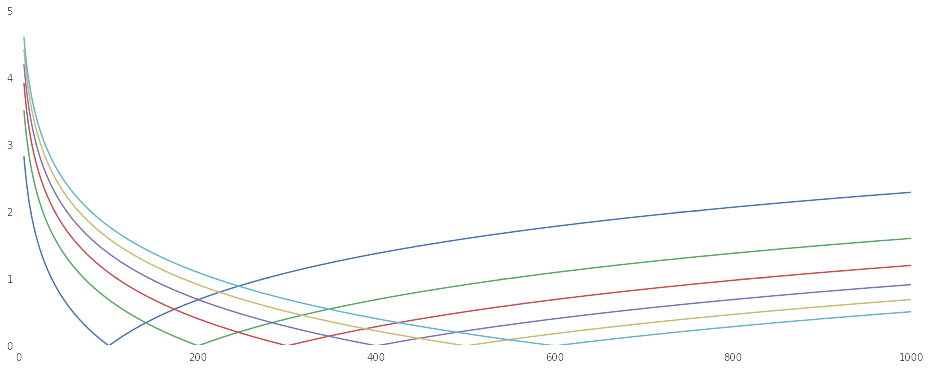

In [238]:
plt.figure(figsize=(16,6))

xs = np.linspace(5, 1000, 1000)
for a in [100, 200, 300, 400, 500, 600]:
    plt.plot(xs, np.abs(math.log(a + 1) - np.log(xs + 1)))

print("Cost of guessing 50% low")
print(800, math.log(801)-math.log(401))
print(400, math.log(401)-math.log(201))
print(200, math.log(201)-math.log(101))
print(100, math.log(101)-math.log(51))
print( 50, math.log(51) -math.log(26))

When the predicted value is close enough to the actual value, the error is symmetric. In other words, guessing high costs the same as guessing low. However, as we predict values further from the actual value, we see a higher penalty for guessing too low than for guessing too high. For instance, `error(a=600, p=400)` is almost twice that of `error(a=600, p=800)`.

There is more asymmetry depending on the actual value. Large actual values will penalize low predictions more harshly than small actual values. For instance, predicting 50% of the actual value 800 has a higher penalty  of 0.6918, compared with predicting 50% of the actual value 100, where the penalty is only 0.6737.

This suggests we might improve our score by either (a) using a regression model with a pluggable cost function or (b) adjusting our predictions where we suspect the model will predict smaller values.

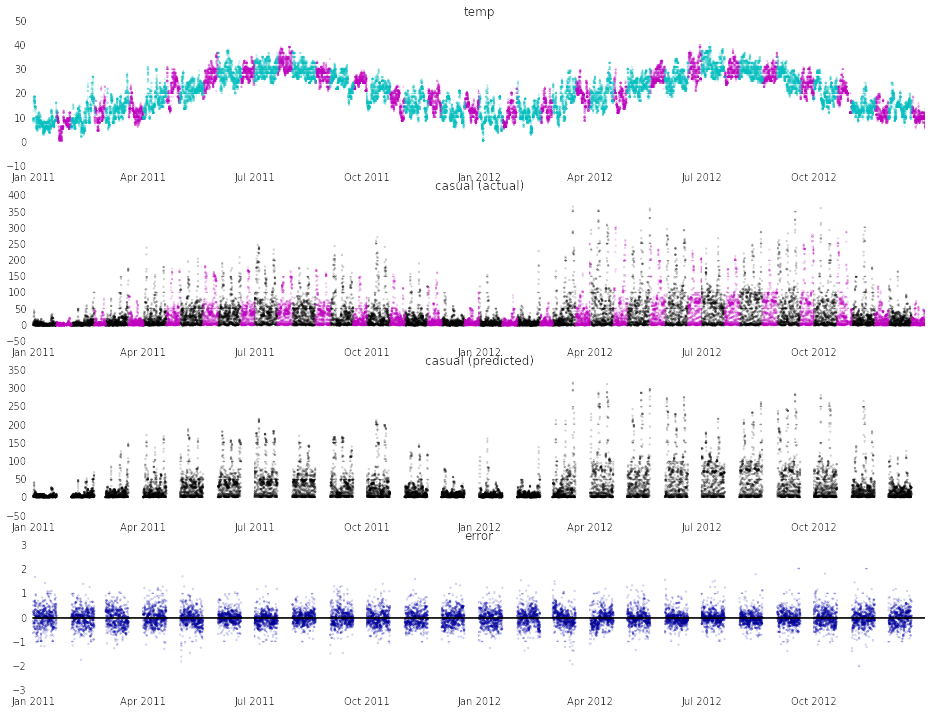

In [213]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16, 12)) # (40, 25)

axes[0].scatter(ftest.index, ftest['temp'], color='m', alpha=0.4, marker='.')
axes[0].scatter(train.index, train['temp'], color='c', alpha=0.4, marker='.')
axes[0].set_xlim(train.index.min(), ftest.index.max())
axes[0].set_title('temp')

ftest['casual'] = cas
axes[1].scatter(train.index, train['casual'], color='k', alpha=0.4, marker='.')
axes[1].scatter(ftest.index, ftest['casual'], color='m', alpha=0.4, marker='.')
axes[1].set_xlim(train.index.min(), ftest.index.max())
axes[1].set_title('casual (actual)')

train['casual_p'] = gbr_casual.predict(train[features]).clip(0, np.max(train.casual_log))
train['casual__'] = np.exp(train.casual_p + mse_casual/2) + 1
axes[2].scatter(train.index, train['casual__'], color='k', alpha=0.4, marker='.')
axes[2].set_xlim(train.index.min(), ftest.index.max())
axes[2].set_title('casual (predicted)')

train['casual_e'] = (train.casual_p - train.casual_log)
axes[3].scatter(train.index, train['casual_e'], alpha=0.4, marker='.')
axes[3].axhline(0, color='k')
axes[3].set_xlim(train.index.min(), ftest.index.max())
axes[3].set_title('error')

plt.show()

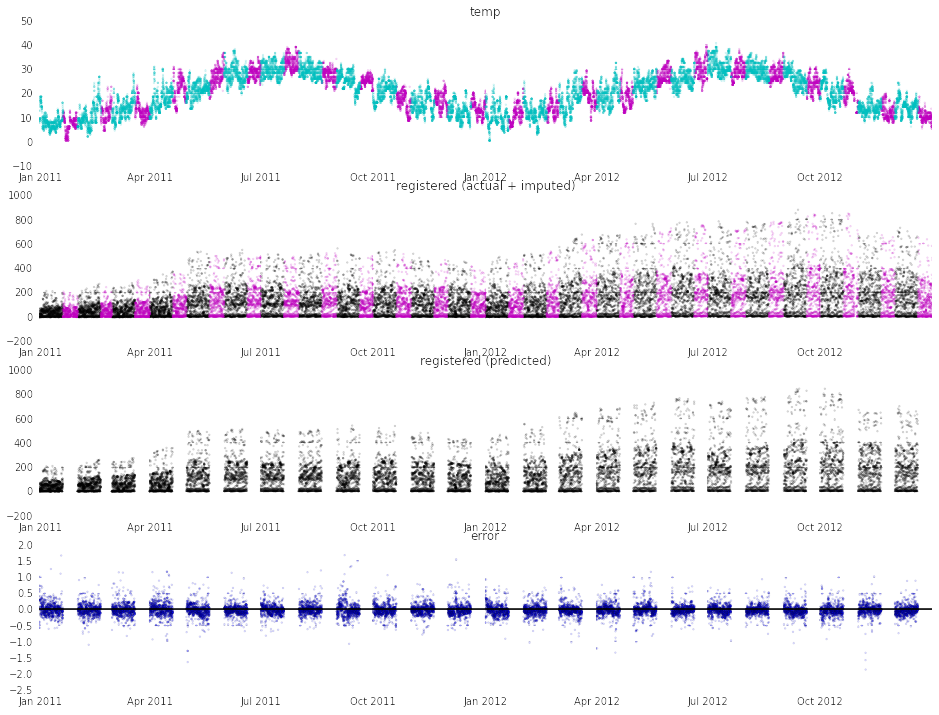

In [239]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16, 12)) # (40, 25)

axes[0].scatter(ftest.index, ftest['temp'], color='m', alpha=0.4, marker='.')
axes[0].scatter(train.index, train['temp'], color='c', alpha=0.4, marker='.')
axes[0].set_xlim(train.index.min(), ftest.index.max())
axes[0].set_title('temp')

ftest['registered'] = reg
axes[1].scatter(train.index, train['registered'], color='k', alpha=0.4, marker='.')
axes[1].scatter(ftest.index, ftest['registered'], color='m', alpha=0.4, marker='.')
axes[1].set_xlim(train.index.min(), ftest.index.max())
axes[1].set_title('registered (actual + imputed)')

train['registered_p'] = gbr_registered.predict(train[features]).clip(0, np.max(train.registered_log))
train['registered__'] = np.exp(train.registered_p + mse_registered/2) + 1
axes[2].scatter(train.index, train['registered__'], color='k', alpha=0.4, marker='.')
axes[2].set_xlim(train.index.min(), ftest.index.max())
axes[2].set_title('registered (predicted)')

train['registered_e'] = (train.registered_p - train.registered_log)
axes[3].scatter(train.index, train['registered_e'], alpha=0.4, marker='.')
axes[3].axhline(0, color='k')
axes[3].set_xlim(train.index.min(), ftest.index.max())
axes[3].set_title('error')

plt.show()